In [1]:
import pandas as pd
# load the dataset
df = pd.read_json('datasets/bbc.json')
# random state
rs = 42
# as usual, explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
id      200 non-null int64
text    200 non-null object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [6]:
# average length of text column
print(df['text'].apply(lambda x: len(x)).mean())

1942.695


In [7]:
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

In [17]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
# join provided stopwords with the default NLTK English stopwords
stopwords = set(sw.words('english'))
def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

In [18]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []

    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            
            # If stopword, ignore token and continue
            if token in stopwords:
                continue
            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue
                
            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)

    return tokens

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['text'])
# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

36385


In [35]:
from sklearn.cluster import KMeans

## Test using elbow to find optimal K
clusters = []
inertia_vals = []

for k in range(1, 40, 1):
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X)

    clusters.append(model)
    inertia_vals.append(model.inertia_)

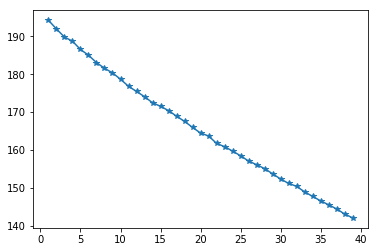

In [36]:
import matplotlib.pyplot as plt
plt.plot(range(1,40,1), inertia_vals, marker='*')
plt.show()

In [40]:
from sklearn.metrics import silhouette_score
for i in range(1,39):
    print(clusters[i])
    print("Silhouette score for k=" + str(i+2), silhouette_score(X, clusters[i].predict(X)), '\n')

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=3 0.0075652070482265035 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 0.008497500664285833 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=5 0.007696267435927205 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.010728209727785498 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clu

Silhouette score for k=38 0.04587351239927417 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=38, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=39 0.04052167387906013 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=39, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=40 0.04126158241119188 



In [56]:
kmeans = KMeans(n_clusters=13, random_state=rs).fit(X)

In [57]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.

    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]

    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()

# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: pakistan, wicket, australia, test, inning, 
Top terms for cluster 1: record, mcilroy, olympic, isinbayeva, indoor, 
Top terms for cluster 2: 6, 7, seed, roddick, agassi, 
Top terms for cluster 3: lion, tour, rugby, new zealand, zealand, 
Top terms for cluster 4: open, hewitt, say, win, australian, 
Top terms for cluster 5: kenteris, greek, thanou, test, iaaf, 
Top terms for cluster 6: liverpool, club, league, gerrard, parry, 
Top terms for cluster 7: radcliffe, marathon, chepkemei, race, paula, 
Top terms for cluster 8: conte, balco, drug, idowu, medal, 
Top terms for cluster 9: south, south africa, africa, vaughan, england, 
Top terms for cluster 10: real, wilkinson, owen, madrid, glazer, 
Top terms for cluster 11: chelsea, minute, goal, ball, wright phillips, 
Top terms for cluster 12: wale, england, ireland, williams, bath, 


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer
    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['text'])

    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
        'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
        'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
        for t in count_vec.vocabulary_]

    return terms

terms = calculate_tf_idf_terms(df['text'])

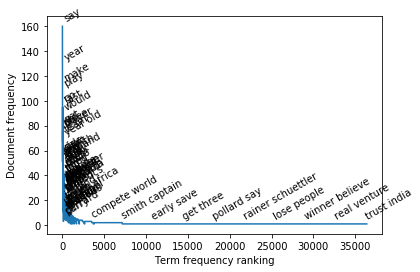

In [64]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 1):
    from scipy.spatial.distance import euclidean
    from math import sqrt

    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step

    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)

    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in terms]

    # plot term frequency ranking vs its DF
    plt.plot(range(len(terms)), [x['df'] for x in terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')

    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])

    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)

        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y

    plt.show()

visualise_zipf(terms)

In [67]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2,max_df=0.8)
X_filter = filter_vec.fit_transform(df['text'])
# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

6923


In [69]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)

Wall time: 2.22 s


In [70]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: goal, say, game, minute, play, 
Top terms for cluster 1: kenteris, drug, test, greek, thanou, 
Top terms for cluster 2: holmes, olympic, world, indoor, record, 
Top terms for cluster 3: england, cup, say, rugby, club, 
Top terms for cluster 4: radcliffe, marathon, race, chepkemei, paula, 
Top terms for cluster 5: 6, roddick, 7, final, open, 
Top terms for cluster 6: wicket, pakistan, ball, run, test, 


In [71]:
from sklearn.cluster import KMeans

## Test using elbow to find optimal K
clusters = []
inertia_vals = []

for k in range(1, 40, 1):
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X_filter)

    clusters.append(model)
    inertia_vals.append(model.inertia_)

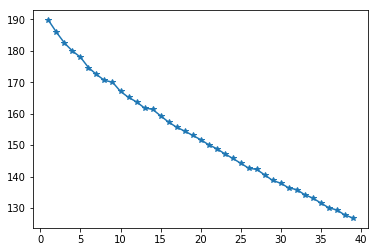

In [72]:
import matplotlib.pyplot as plt
plt.plot(range(1,40,1), inertia_vals, marker='*')
plt.show()

In [76]:
from sklearn.metrics import silhouette_score
for i in range(1,40):
    print(clusters[i])
    print("Silhouette score for k=" + str(i+2), silhouette_score(X_filter, clusters[i].predict(X_filter)), '\n')

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=3 0.01666492156749577 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 0.020184980361855728 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=5 0.021926268381954578 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.022771204304307183 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clust

Silhouette score for k=39 0.07472047880982872 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=39, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=40 0.06848230209922018 



IndexError: list index out of range

In [77]:
from sklearn.cluster import KMeans

## Test using elbow to find optimal K
clusters = []
inertia_vals = []

for k in range(1, 12, 1):
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X_filter)

    clusters.append(model)
    inertia_vals.append(model.inertia_)

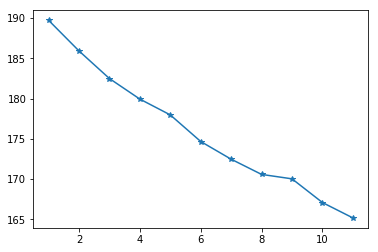

In [78]:
import matplotlib.pyplot as plt
plt.plot(range(1,12,1), inertia_vals, marker='*')
plt.show()

In [82]:
from sklearn.metrics import silhouette_score
for i in range(1,11):
    print(clusters[i])
    print("Silhouette score for k=" + str(i+1), silhouette_score(X_filter, clusters[i].predict(X_filter)), '\n')

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=2 0.01666492156749577 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=3 0.020184980361855728 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 0.021926268381954578 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=5 0.022771204304307183 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clust

In [84]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=8, random_state=rs).fit(X_filter)

Wall time: 1.75 s


In [85]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: ball, pakistan, wicket, test, day, 
Top terms for cluster 1: 6, 7, roddick, final, seed, 
Top terms for cluster 2: radcliffe, marathon, chepkemei, race, cross country, 
Top terms for cluster 3: england, rugby, lion, tour, new, 
Top terms for cluster 4: conte, drug, balco, ban, say, 
Top terms for cluster 5: kenteris, greek, thanou, iaaf, test, 
Top terms for cluster 6: holmes, year, world, britain, athletics, 
Top terms for cluster 7: say, goal, liverpool, club, game, 
